## Sentiment Analysis on PhonePe App Reviews


### Install & Import Libraries

In [ ]:
# Install required libraries
!pip install google_play_scraper vaderSentiment wordcloud scikit-learn transformers --quiet

# Import libraries
from google_play_scraper import reviews
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Scrape Google Play Reviews

In [ ]:
# Fetch app reviews
result, _ = reviews(
    'com.phonepe.app',   
    lang='en',
    country='in',
    count=10000
)

# Convert to DataFrame
df = pd.DataFrame(result)
df.head()


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c3798a88-1605-43c0-b418-59306bc11206,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,nice app,5,0,24.09.06.0,2025-04-12 12:51:46,None,NaT,24.09.06.0
1,0a7fce17-3c51-4c14-9436-e6b031f9cbea,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,nice,5,0,25.03.21.0,2025-04-12 12:51:27,None,NaT,25.03.21.0
2,dca9e635-547f-4393-a14b-eab6818adb9b,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,ok,5,0,25.03.21.0,2025-04-12 12:51:20,None,NaT,25.03.21.0
3,2588a68a-77cc-450d-b66f-0057875f1503,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,The update logo becomes redundant,1,0,None,2025-04-12 12:50:13,"Hi, Hussain. We are not able to gauge exactly ...",2025-04-12 17:43:54,None
4,e4da17b6-3e3b-4cd3-bbe9-7ba9a6ff78ab,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,good 👍,3,0,None,2025-04-12 12:48:59,"Hello, Faizan. We appreciate your positive fee...",2025-04-12 17:45:03,None


### Clean & Preprocess Text

In [82]:
# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['clean_content'] = df['content'].apply(clean_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['clean_content'] = df['clean_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
df[['content', 'clean_content']].head(10)


,content,clean_content
0,nice app,nice app
1,nice,nice
2,ok,ok
3,The update logo becomes redundant,update logo becomes redundant
4,good 👍,good
5,if scan to pay it not show wallet option to tr...,scan pay show wallet option transfer money
6,very nice app,nice app
7,I just love it. it's my go to payment app . I ...,love go payment app love service colorful keep...
8,bekat update 👎🏻👎🏻👎🏻,bekat update
9,I love this app,love app


###  Sentiment Analysis using VADER

<ipython-input-83-301ee21d44c9>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='viridis')


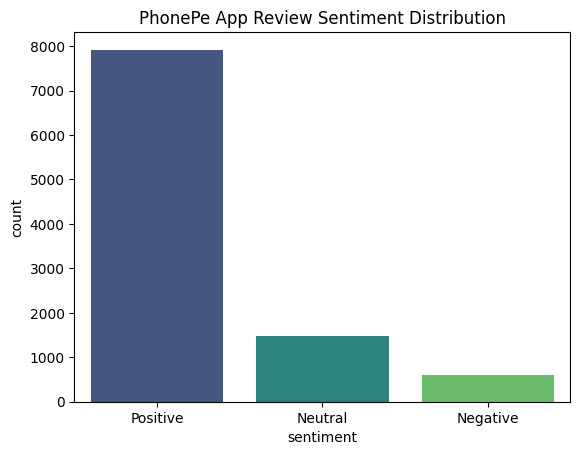

In [83]:
# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Sentiment scoring function
def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis
df['sentiment'] = df['clean_content'].apply(get_sentiment)

# Sentiment Distribution Plot
sns.countplot(data=df, x='sentiment', palette='viridis')
plt.title('PhonePe App Review Sentiment Distribution')
plt.show()


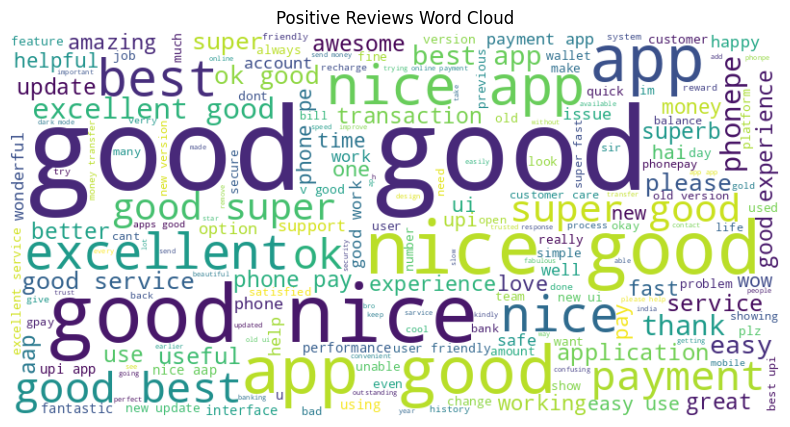

In [84]:
positive_text = " ".join(review for review in df[df['sentiment'] == 'Positive']['clean_content'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()


### Sentiment Trend Over Time

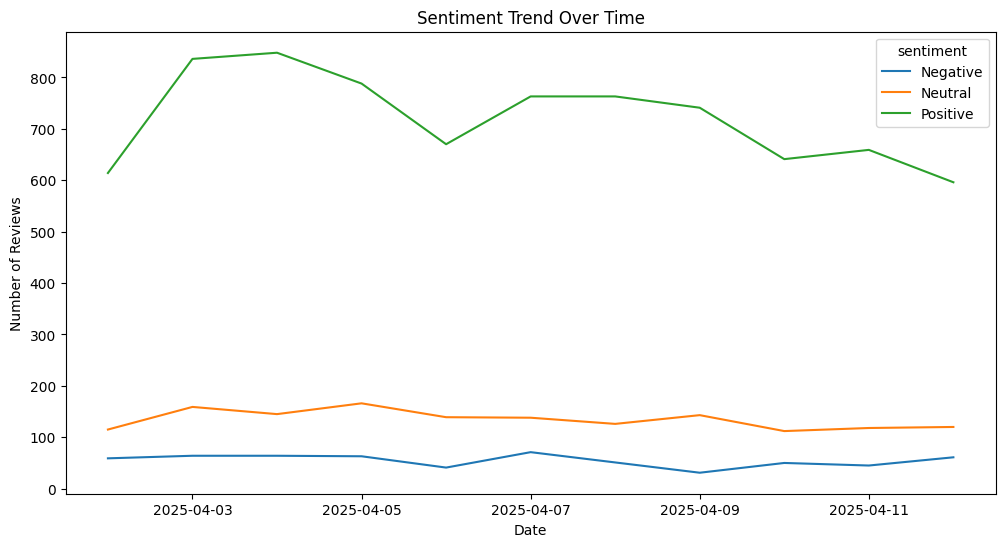

In [ ]:
df['at'] = pd.to_datetime(df['at'])
sentiment_trend = df.groupby([df['at'].dt.date, 'sentiment']).size().unstack().fillna(0)

sentiment_trend.plot(figsize=(12,6))
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()


###  Sentiment Analysis using BERT

Device set to use cuda:0
<ipython-input-86-1ea6f3a9b265>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='bert_sentiment_final', palette='magma')


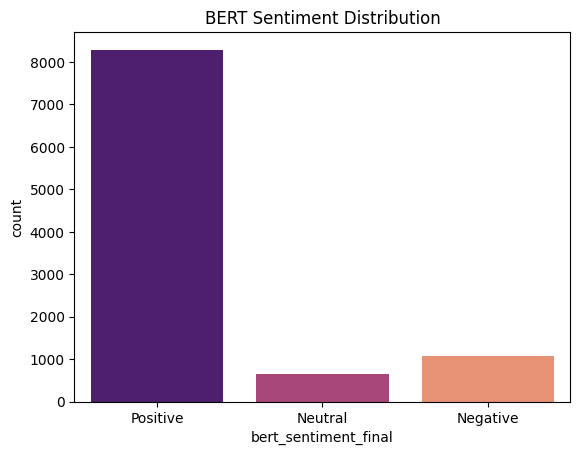

In [86]:
# Load BERT model
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Apply BERT sentiment analysis
df['bert_sentiment'] = df['clean_content'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

# Map BERT labels to categories
def map_sentiment(label):
    if label in ['4 stars', '5 stars']:
        return 'Positive'
    elif label == '3 stars':
        return 'Neutral'
    else:
        return 'Negative'

df['bert_sentiment_final'] = df['bert_sentiment'].apply(map_sentiment)

# BERT Sentiment Distribution
sns.countplot(data=df, x='bert_sentiment_final', palette='magma')
plt.title('BERT Sentiment Distribution')
plt.show()


### Compare VADER vs BERT

<ipython-input-87-b983353c01db>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_match', data=df, palette='coolwarm')


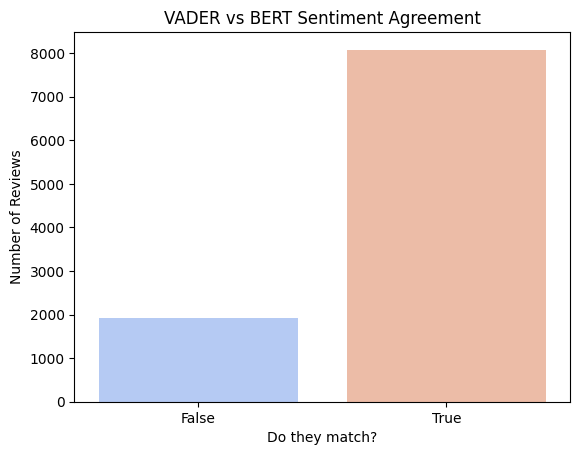

VADER and BERT agree 80.76% of the time.


In [87]:
# Compare sentiments
df['sentiment_match'] = df['sentiment'] == df['bert_sentiment_final']

# Agreement count plot
sns.countplot(x='sentiment_match', data=df, palette='coolwarm')
plt.title('VADER vs BERT Sentiment Agreement')
plt.xlabel('Do they match?')
plt.ylabel('Number of Reviews')
plt.show()

# Agreement Percentage
accuracy = df['sentiment_match'].mean() * 100
print(f"VADER and BERT agree {accuracy:.2f}% of the time.")


### Topic Modeling with KMeans

In [88]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
X = vectorizer.fit_transform(df['clean_content'])

# KMeans Clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)
df['topic_cluster'] = kmeans.labels_

# Top Keywords per Cluster
def get_top_keywords(n_terms):
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    return [[terms[ind] for ind in order_centroids[i, :n_terms]] for i in range(k)]

keywords_per_topic = get_top_keywords(10)

# Print keywords
for idx, topic in enumerate(keywords_per_topic):
    print(f"Topic {idx+1}: {topic}")


Topic 1: ['nice', 'app', 'aap', 'work', 'good', 'service', 'experience', 'application', 'working', 'payment']
Topic 2: ['good', 'app', 'really', 'work', 'nice', 'ha', 'guys', 'gud', 'great', 'gpay']
Topic 3: ['best', 'app', 'payment', 'upi', 'service', 'aap', 'application', 'experience', 'online', 'apps']
Topic 4: ['super', 'app', 'fast', 'service', 'good', 'nice', 'payment', 'phonepe', 'excellent', 'upi']
Topic 5: ['excellent', 'app', 'ok', 'good', 'service', 'phone', 'experience', 'payment', 'easy', 'bad']


### WordClouds by Cluster

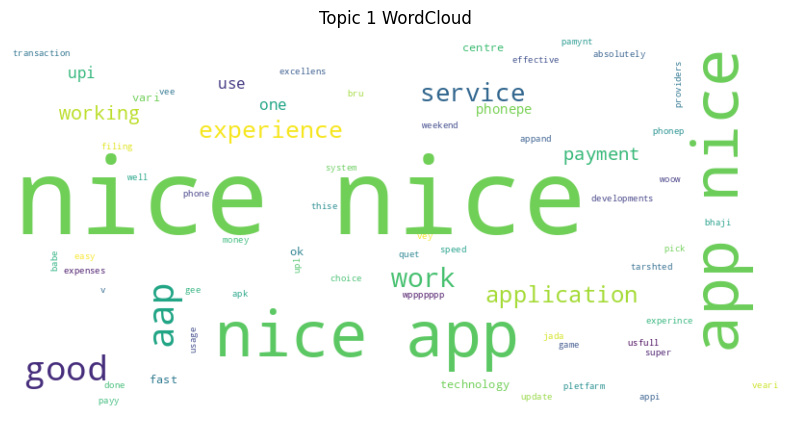

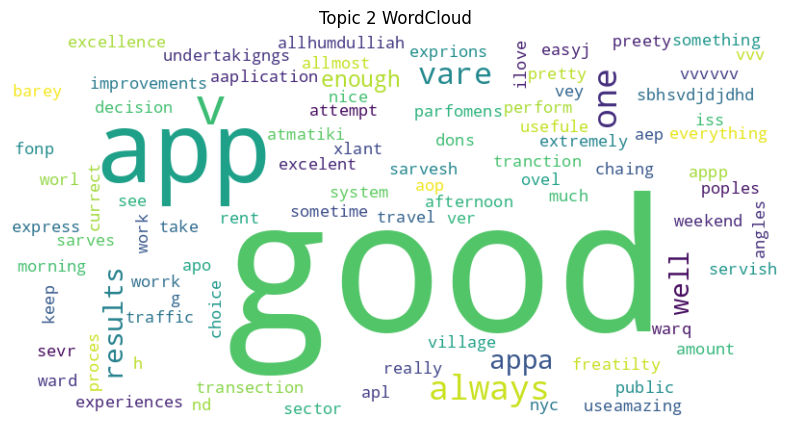

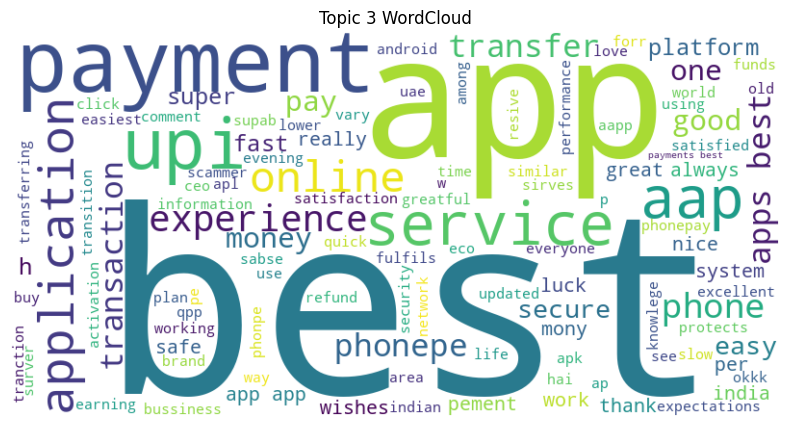

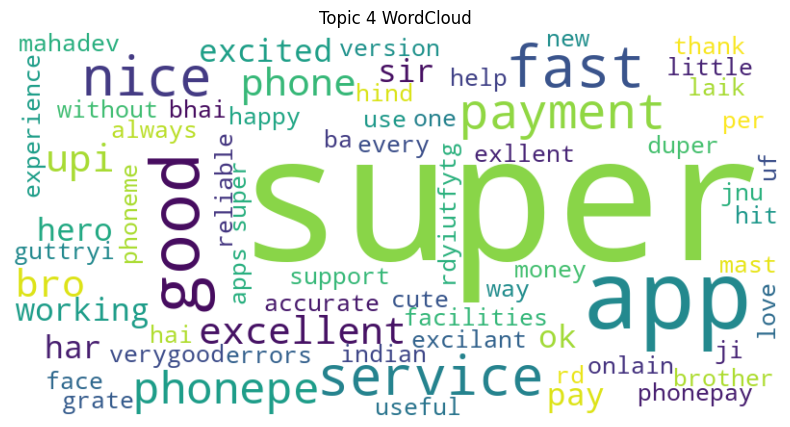

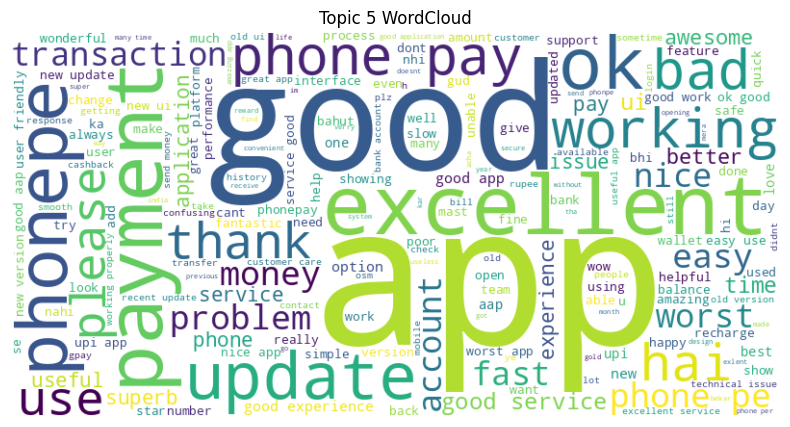

In [ ]:
for i in range(k):
    cluster_reviews = df[df['topic_cluster'] == i]['clean_content']
    text = " ".join(cluster_reviews)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {i+1} WordCloud')
    plt.show()

### Topic Modeling with LDA

In [90]:
lda_model = LatentDirichletAllocation(n_components=k, random_state=42)
lda_model.fit(X)

def get_lda_topics(model, vectorizer, n_words=10):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx+1}: ", [words[i] for i in topic.argsort()[:-n_words - 1:-1]])

get_lda_topics(lda_model, vectorizer)


Topic 1:  ['best', 'excellent', 'service', 'fast', 'awesome', 'easy', 'helpful', 'apps', 'happy', 'safe']
Topic 2:  ['nice', 'super', 'aap', 'thank', 'wow', 'osm', 'slow', 'poor', 'beautiful', 'cool']
Topic 3:  ['ok', 'experience', 'update', 'use', 'useful', 'superb', 'new', 'hai', 'application', 'phone']
Topic 4:  ['good', 'great', 'work', 'mast', 'perfect', 'outstanding', 'exllent', 'goog', 'nise', 'lovely']
Topic 5:  ['app', 'payment', 'working', 'pay', 'bad', 'upi', 'phone', 'amazing', 'money', 'better']


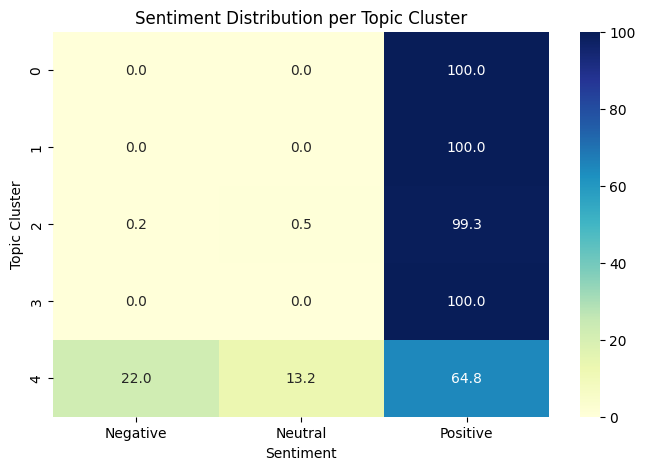

In [91]:
sentiment_topic_crosstab = pd.crosstab(df['topic_cluster'], df['bert_sentiment_final'], normalize='index') * 100

plt.figure(figsize=(8, 5))
sns.heatmap(sentiment_topic_crosstab, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Sentiment Distribution per Topic Cluster')
plt.xlabel('Sentiment')
plt.ylabel('Topic Cluster')
plt.show()


### Category Mapping using Keywords

category
Other                7952
Positive Feedback    1078
Service Issue         422
Features Related      308
Bug                   240
Name: count, dtype: int64


<ipython-input-92-81125afd7463>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='category', palette='viridis')


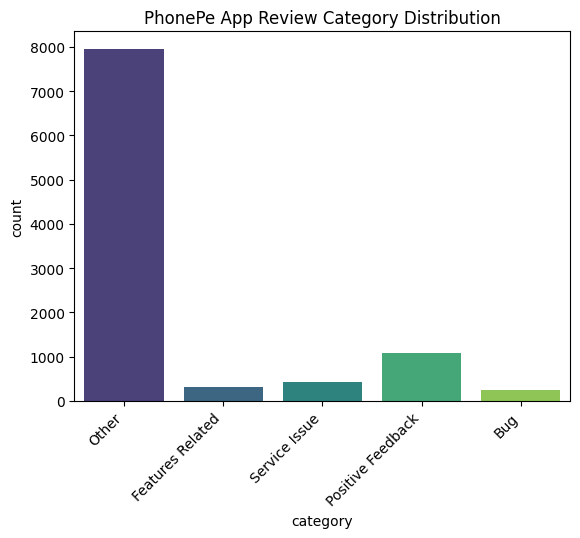

In [ ]:
category_mapping = {
    "Bug": ["bug", "error", "crash", "glitch", "issue", "problem", "defect", "malfunction"],
    "Service Issue": ["transaction", "payment", "customer service", "support", "refund", "down"],
    "Features Related": ["add", "feature", "improve", "update", "option", "setting"],
    "Positive Feedback": ["great", "awesome", "love", "best", "excellent", "easy"],
    "Other": []  # Catch-all for reviews that don't fit other categories
}

def categorize_review(review_text):
    for category, keywords in category_mapping.items():
        if any(keyword in review_text.lower() for keyword in keywords):
            return category
    return "Other"  

df['category'] = df['clean_content'].apply(categorize_review)

category_counts = df['category'].value_counts()
print(category_counts)

# Visualization
sns.countplot(data=df, x='category', palette='viridis')
plt.title('PhonePe App Review Category Distribution')
plt.xticks(rotation=45, ha='right')  
plt.show()



### Subcategorizing ‘Other’ Reviews with LDA


In [93]:
other_reviews = df[df['category'] == 'Other']['clean_content']

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
X_other = vectorizer.fit_transform(other_reviews)


In [94]:
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X_other)

LatentDirichletAllocation(n_components=5, random_state=42)

In [95]:
def get_lda_topics(model, vectorizer, n_words=10):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx+1}: ", [words[i] for i in topic.argsort()[:-n_words - 1:-1]])

get_lda_topics(lda_model, vectorizer)

Topic 1:  ['good', 'happy', 'exllent', 'waste', 'pic', 'thats', 'im', 'job', 'application', 'today']
Topic 2:  ['nice', 'super', 'useful', 'work', 'wow', 'application', 'mast', 'wonderful', 'worst', 'thanks']
Topic 3:  ['experience', 'bad', 'phone', 'working', 'thank', 'phonepe', 'pay', 'like', 'upi', 'better']
Topic 4:  ['app', 'service', 'fast', 'use', 'apps', 'osm', 'hai', 'slow', 'acha', 'supar']
Topic 5:  ['ok', 'aap', 'superb', 'amazing', 'ui', 'fantastic', 'gud', 'performance', 'exlent', 'poor']


In [96]:
# Assign topic labels as subcategories for others
topic_labels = {
    0: "Service Experience",
    1: "Positive Feedback",
    2: "Mixed Feedback",
    3: "Positive Feedback",
    4: "App Performance"
}

# Get the predicted topic numbers
predicted_topics = lda_model.transform(X_other).argmax(axis=1)

# Map the topic numbers to labels using pandas Series
df.loc[df['category'] == 'Other', 'subcategory'] = pd.Series(predicted_topics).map(topic_labels)

# Concatenate 'category' and 'subcategory' for refined categories
df['refined_category'] = df['category'].where(df['category'] != 'Other', df['subcategory'])

<ipython-input-97-b78308da23d3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='refined_category', palette='viridis', order=df['refined_category'].value_counts().index)


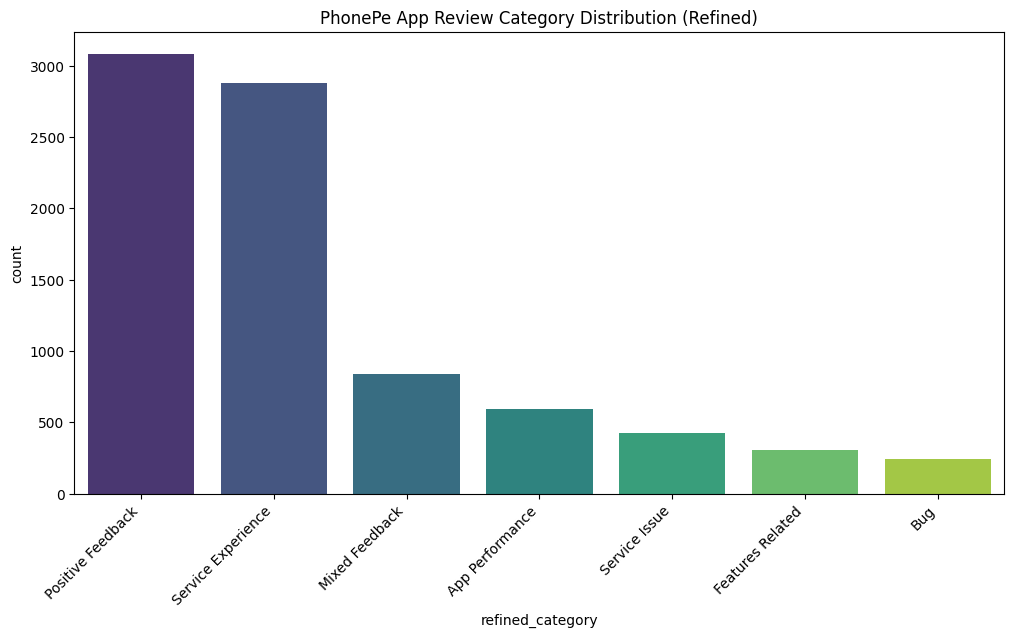

In [ ]:
# Visualization
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.countplot(data=df, x='refined_category', palette='viridis', order=df['refined_category'].value_counts().index)
plt.title('PhonePe App Review Category Distribution (Refined)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()